In [41]:
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [10]:
# sigmoid function for nd; return the value of sigmoid with argument beta
# q can be n dimensional, either list or int/float
# beta should be between 0 and 1; determine the sharpness of sigmoid
# we can also try different functions here
def sigmoid(beta,q):
    q=np.array(q)
    val = 1/(1+np.exp(0-beta*q))
    return val
def ratchose(Q): # 0 means left
    if random.uniform(0,1)<sigmoid(beta,Q[0]-Q[1]):
        return np.array([1,0])
    else:
        return np.array([0,1]) 

In [11]:
class toyQ_2choice:
    '''a unchanging env with probability of giving one
    of two rewards based on params to two different choices'''
    obs_size=1
    action_size=2
    def __init__(self,left=0.2,right=0.8,state=0):
        self.left=left
        self.right=right
        self.obslog=[]
        self.state=state
    def step(self,action,state=0):
        '''takes in the action param as a int of 0 or 1
        where 0 is go left and 1 is to right, and returns
        a return reward where 0 is no reward'''
        reward_site = random.uniform(0,1)
        if reward_site < self.right and np.array_equal(action,np.array([0,1])):
            #if the rat goes right and the reward is on the right
            obs=np.array([0,1])
        elif reward_site >= self.right and np.array_equal(action,np.array([1,0])):
            obs=np.array([1,0])
        else:
            obs=np.array([0,0])
        self.obslog.append(obs)
        return obs
    
class WSLS_rat: # to-do
    pass

class sig_rat:
    def __init__(self,env,alpha=0.2,beta=-4,gamma=0):
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.choiceLog=[]
        self.beta=beta
        self.gamma=gamma
        self.env=env
        self.alpha=alpha
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,)) # Q-table starts from 0
        self.Qlog=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self): # 0 means left
        if random.uniform(0,1)<sigmoid(self.beta,self.Q[self.env.state][0]-self.Q[self.env.state][1]):
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Takes obs/reward and update its Q-table'''
        self.Q[self.env.state] = self.Q[self.env.state] + self.alpha*self.choice*\
        (obs + self.gamma*np.max(self.Q[self.env.state])-self.Q[self.env.state])
        self.Qlog=np.vstack((self.Qlog,self.Q))
        return self.Q[self.env.state]
    
class FSrat:
    def __init__(self,env,alphaF=0.2,alphaS=0.1,beta=-4,gamma=0): # fail and success
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.choiceLog=[]
        self.beta=beta
        self.env=env
        self.alphaF=alphaF
        self.gamma=gamma
        self.alphaS=alphaS
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,)) # Q-table starts from 0
        self.Qlog=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self): #[1,0] means left
        if random.uniform(0,1)<sigmoid(self.beta,self.Q[self.env.state][0]-self.Q[self.env.state][1]):
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Takes obs/reward and update its Q-table'''
        used_alpha=[self.alphaF,self.alphaS][max(obs)]
        self.Q[self.env.state] = self.Q[self.env.state] + used_alpha*self.choice*\
        (obs + self.gamma*np.max(self.Q[self.env.state])-self.Q[self.env.state])
        self.Qlog=np.vstack((self.Qlog,self.Q))
        return self.Q[self.env.state]
    
    
    
def train_rat(env,rat,it_num,every=500):
    for i in range(it_num):
        action=rat.get_choice()
        obs=env.step(action)
        rat.update(obs)
        if i%every==-1:
            print(np.mean(rat.Qlog,axis=0))
    return env,rat


In [ ]:
# demo
env=toyQ_2choice()
rat=sig_rat(env,alpha=0.02)
env,rat=train_rat(env,rat,5000)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

## Maximum Likelihood Estimation on beta

we cannot give MLE for Q's since likelihood is a function of Q, that is, Q is changing at every timepoint

Given the actions(i.e. the turns) and Q value of the agent in every round, maximum likelihood estimation of beta are given here.

The action of agent is given by a sigmoid-like function of Q, beta as a parameter.

In [23]:
#for test use
#actions = np.random.choice([0,1], size=3, p=[0.2,0.8]) # 0=left, 1=right
#rewards = np.random.choice([0,1], size=3, p=[0.2,0.8])

In [24]:
#Q = np.array([[0,0],[0,0.2],[0.2,0.36]])    #,[0.36,0.688]
#beta0 = 0

In [31]:
# parameter: x, a numpy array of action data; beta, the optimal beta found in simulation; Q, 2d numpy array of QL, QR
# x and Q should be of same (row) length
# return the sum of log-likelihood
def neg_log_likelihood(beta,x,Q): 
    n = len(x)
    sum_ll = 0
    for i in range(n):
        dQ = Q[i][0] - Q[i][1]
        if np.array_equal(x[i],np.array([1,0])):
            prob = 1/(np.exp(0-beta*dQ)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*dQ)+1)
        
        sum_ll = sum_ll - np.log(prob)
    
    return sum_ll

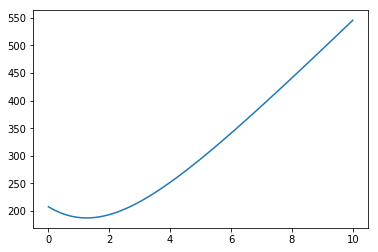

In [26]:
import matplotlib.pyplot as plt
beta_plot = np.linspace(0,10,100)
plt.plot(beta_plot, neg_log_likelihood(beta_plot,actions,Q))
plt.show()

In [68]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_beta(actions,Q,beta0):    
    result = minimize(neg_log_likelihood,beta0, args=(actions,Q))
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge')
    return result
    
    

In [61]:
# return mse between simulated Q and Q_hat calculated with optimal beta from MLE
def Q_distance(iteration,alpha,beta0):
    env = toyQ_2choice()
    rat = sig_rat(env, alpha=alpha, beta=beta0)
    env,rat = train_rat(env,rat,iteration)
    Q = np.array(rat.Qlog)
    actions = rat.choiceLog
    
    beta_hat = MLE_beta(actions,Q,beta0).x[0]
    
    rat_hat = sig_rat(env, alpha=alpha, beta=beta_hat)
    env,rat = train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    #Q[0]=[0,0] does not matter
    mse = np.linalg.norm(Q-Q_hat)**2/iteration 
    #axis=None perform mean elementwise   (np.square(Q-Q_hat)).mean(axis=None)*2
    
    return mse
    
    

In [62]:
#test
Q_distance(300,0.2,0.3)

Optimization terminated successfully.
The MLE for beta is [0.27691303]
Iteration = 3


0.06262544325482636

In [63]:
#
beta0_list = [-10,-4,-2,-1,-0.8,-0.5,-0.2,0.2,0.5,0.8,1,2,4,10]
mse_list = []
alpha = 0.2
iteration=300
for i in range(len(beta0_list)):
    mse = Q_distance(iteration,alpha,beta0_list[i])
    mse_list.append(mse)

Optimization terminated successfully.
The MLE for beta is [-8.72275433]
Iteration = 5
Optimization terminated successfully.
The MLE for beta is [-4.25962496]
Iteration = 3
Optimization terminated successfully.
The MLE for beta is [-2.07499777]
Iteration = 4
Optimization terminated successfully.
The MLE for beta is [-1.16749649]
Iteration = 4
Optimization terminated successfully.
The MLE for beta is [-0.90110036]
Iteration = 3
Optimization terminated successfully.
The MLE for beta is [-0.36125609]
Iteration = 3
Optimization terminated successfully.
The MLE for beta is [-0.14628164]
Iteration = 4
Optimization terminated successfully.
The MLE for beta is [-0.22484624]
Iteration = 3
Optimization terminated successfully.
The MLE for beta is [0.52061223]
Iteration = 3
Optimization terminated successfully.
The MLE for beta is [0.44302733]
Iteration = 4
Optimization terminated successfully.
The MLE for beta is [0.94062586]
Iteration = 4
Optimization terminated successfully.
The MLE for beta is

In [69]:
#
beta0_list = np.linspace(-10,10,100)
mse_list = []
alpha = 0.2
iteration=300
for i in range(len(beta0_list)):
    mse = Q_distance(iteration,alpha,beta0_list[i])
    mse_list.append(mse)

The optimization did not converge


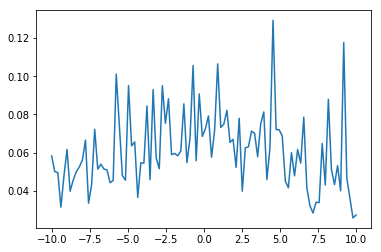

In [70]:
#plot
plt.plot(beta0_list,mse_list)
plt.show()